In [1]:
pip install fastkaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Please follow the steps below to download and use kaggle data within Google Colab:

1. Go to your account, Scroll to API section and Click Expire API Token to remove previous tokens

2. Click on Create New API Token - It will download kaggle.json file on your machine.

3. Go to your Google Colab project file and run the following commands:

1) ! pip install -q kaggle

2) from google.colab import files

files.upload()

Choose the kaggle.json file that you downloaded
3) ! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

Make directory named kaggle and copy kaggle.json file there.
4) ! chmod 600 ~/.kaggle/kaggle.json

Change the permissions of the file.
5) ! kaggle datasets list
- That's all ! You can check if everything's okay by running this command.

Download Data
! kaggle competitions download -c 'name-of-competition'

Use unzip command to unzip the data:

For example,

Create a directory named train,

! mkdir train

unzip train data there,

! unzip train.zip -d train

In [3]:
!pip install -q kaggle

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bconstantine","key":"54aaddafac2bdb50f0a1c43d11ccab60"}'}

In [5]:
! mkdir ~/.kaggle

In [6]:
! cp kaggle.json ~/.kaggle/

In [7]:
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
 ! kaggle datasets list

ref                                                    title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
deepcontractor/mcdonalds-india-menu-nutrition-facts    McDonald's India : Menu Nutrition Dataset          5KB  2022-07-28 17:08:52           3598        147  0.9411765        
iamsouravbanerjee/house-rent-prediction-dataset        House Rent Prediction Dataset                     82KB  2022-08-20 13:49:03           3692        132  1.0              
arianazmoudeh/airbnbopendata                           Airbnb Open Data                                  10MB  2022-08-01 15:58:10           2290         81  0.9705882        
ericsims/world-cheese-awards-worlds-cheesiest-dataset  World Cheese Awards (World's Cheesiest Dataset)   49KB  2022-08-1

In [9]:
pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 509 kB 5.2 MB/s 


In [10]:
import timm
from fastai.vision.all import *
from fastkaggle import *
comp = 'paddy-disease-classification'

path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

100%|██████████| 1.02G/1.02G [00:11<00:00, 94.0MB/s]


In [11]:
path

Path('paddy-disease-classification')

In [12]:
set_seed(42)

path.ls()

(#4) [Path('paddy-disease-classification/test_images'),Path('paddy-disease-classification/train.csv'),Path('paddy-disease-classification/train_images'),Path('paddy-disease-classification/sample_submission.csv')]

In [13]:
trn_path = path/'train_images'
files = get_image_files(trn_path)

(480, 640)


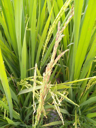

In [14]:
img = PILImage.create(files[0])
print(img.size)
img.to_thumb(128)

# Preprocess data

In [ ]:
from fastcore.parallel import *

def f(o): return PILImage.create(o).size
sizes = parallel(f, files, n_workers=8)
pd.Series(sizes).value_counts()

(480, 640)    10403
(640, 480)        4
dtype: int64

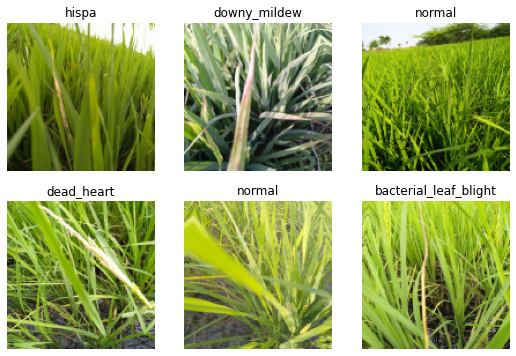

In [ ]:
#squish to 480x480, then random  resized crop with aug)transforms
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42,
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75))

dls.show_batch(max_n=6)

# Model part 1

In [ ]:
learn = vision_learner(dls, 'resnet26d', metrics=error_rate, path='.').to_fp16() #to floating point 16 precision

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet26d-69e92c46.pth" to /root/.cache/torch/hub/checkpoints/resnet26d-69e92c46.pth


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


SuggestedLRs(valley=0.0014454397605732083, slide=0.004365158267319202)

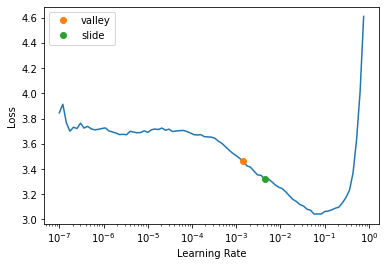

In [ ]:
learn.lr_find(suggest_funcs=(valley, slide))

In [ ]:
#lr_find generally recommends rather conservative learning rates, to ensure that your model will train successfully. I generally like to push it a bit higher if I can.
#try a few epochs
learn.fine_tune(3, 0.01)

epoch,train_loss,valid_loss,error_rate,time
0,1.746436,1.212939,0.391158,01:38


epoch,train_loss,valid_loss,error_rate,time
0,1.142727,0.844634,0.277751,01:36
1,0.779692,0.476676,0.146084,01:37
2,0.537724,0.412483,0.125420,01:41


In [ ]:
tst_files = get_image_files(path/'test_images').sorted() #we need csv in sorted alphabetical order
tst_dl = dls.test_dl(tst_files)

In [ ]:
probs,_,idxs = learn.get_preds(dl=tst_dl, with_decoded=True)
idxs
#the empty middle is the class, while the idxs is the class index

TensorBase([7, 8, 4,  ..., 8, 1, 5])

In [ ]:
dls.vocab #.vocab automatically store the list of classes

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

In [ ]:
#apply to mapping 
mapping = dict(enumerate(dls.vocab))
results = pd.Series(idxs.numpy(), name="idxs").map(mapping)
results

0                       hispa
1                      normal
2                  brown_spot
3                       blast
4                       blast
                ...          
3464               dead_heart
3465                    hispa
3466                   normal
3467    bacterial_leaf_streak
3468               dead_heart
Name: idxs, Length: 3469, dtype: object

In [ ]:
ss = pd.read_csv(path/'sample_submission.csv')
ss['label'] = results
ss.to_csv('subm.csv', index=False)
!head subm.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,brown_spot
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,normal


In [ ]:
if not iskaggle:
    from kaggle import api
    api.competition_submit_cli('subm.csv', 'initial rn26d 128px', comp)

100%|██████████| 69.9k/69.9k [00:02<00:00, 25.9kB/s]


# Model Part 2

In [ ]:
# try cutting each length and width by 2 on each side
trn_path = Path('sml')
resize_images(path/'train_images', dest=trn_path, max_size=256, recurse=True)

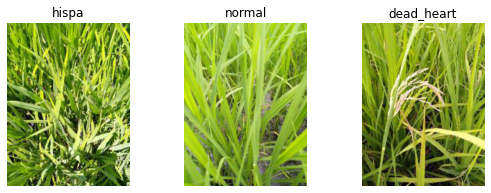

In [ ]:
# resize to universal size 192x256px images, keeping the same dimension of 3:4 ratio
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42,
    item_tfms=Resize((256,192))) 

dls.show_batch(max_n=3)

In [ ]:
#apply modelling in function to make it easier
def train(arch, item, batch, epochs=5):
    dls = ImageDataLoaders.from_folder(trn_path, seed=42, valid_pct=0.2, item_tfms=item, batch_tfms=batch)
    learn = vision_learner(dls, arch, metrics=error_rate).to_fp16()
    learn.fine_tune(epochs, 0.01)
    return learn

In [ ]:
#item transform already set to 192x192, so accuracy shouldnot affect that much
learn = train('resnet26d', item=Resize(192),
              batch=aug_transforms(size=128, min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,time
0,1.902255,1.405560,0.435368,00:36


epoch,train_loss,valid_loss,error_rate,time
0,1.269086,0.986914,0.331091,00:34
1,1.008957,0.770448,0.246516,00:29
2,0.697879,0.501155,0.159058,00:31
3,0.554760,0.417180,0.135992,00:30
4,0.438962,0.391034,0.126862,00:30


In [ ]:
#try other variant: 
arch = 'convnext_small_in22k'
learn = train(arch, item=Resize(192, method='squish'),
              batch=aug_transforms(size=128, min_scale=0.75))

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_small_22k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_small_22k_224.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.316599,0.866050,0.272465,00:37


epoch,train_loss,valid_loss,error_rate,time
0,0.603342,0.445350,0.147045,00:41
1,0.511097,0.282656,0.084094,00:47
2,0.322029,0.189676,0.062951,00:43
3,0.184033,0.141170,0.038924,00:47
4,0.132332,0.127856,0.038924,00:45


In [ ]:
#try preprocess not by squish but by crop, just like what is defined inside fastai by default
learn = train(arch, item=Resize(192),
              batch=aug_transforms(size=128, min_scale=0.75))
#result actually not change that much

epoch,train_loss,valid_loss,error_rate,time
0,1.355305,0.859705,0.284959,00:32


epoch,train_loss,valid_loss,error_rate,time
0,0.740556,0.492273,0.165305,00:40
1,0.540945,0.291143,0.096108,00:44
2,0.365364,0.199230,0.061028,00:43
3,0.231446,0.155207,0.047093,00:41
4,0.168991,0.148626,0.043729,00:43


In [ ]:
#try also another method: padding with zeros, looks like it improves
learn = train(arch, item=Resize((256,192), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
      batch=aug_transforms(size=(171,128), min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,time
0,1.282418,0.771663,0.259491,00:34


epoch,train_loss,valid_loss,error_rate,time
0,0.633641,0.433973,0.146084,00:43
1,0.531722,0.289355,0.092744,00:42
2,0.344938,0.217067,0.069678,00:43
3,0.211211,0.135430,0.042287,00:45
4,0.139170,0.128458,0.037482,00:43


In [ ]:
#try also TTA to get good prediction
#During inference or validation, creating multiple versions of each image, using data augmentation, and then taking the average or maximum of the predictions for each augmented version of the image.
#trying the result without tta applied
valid = learn.dls.valid #dont forget about learn.!
preds,targs = learn.get_preds(dl=valid)

In [ ]:
error_rate(preds, targs)
#the same error rate, it means our model have behave correctly

TensorBase(0.0375)

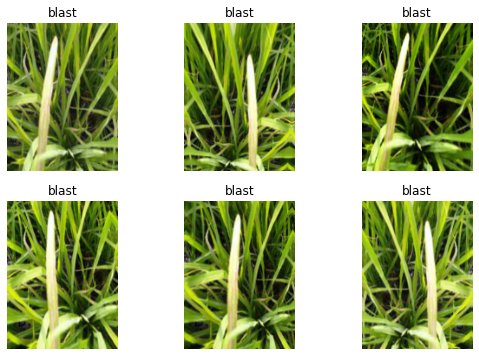

In [ ]:
learn.dls.train.show_batch(max_n=6, unique=True)
#show what tta does to our training batch(only for preview, training is not used)

In [ ]:
#now try with tta applied
tta_preds,_targs = learn.tta(dl=valid) #return = tta_preds and targs

In [ ]:
error_rate(tta_preds, targs) 

TensorBase(0.0332)

In [ ]:
#scale to larger image
trn_path = path/'train_images'
learn = train(arch, epochs=12,
              item=Resize((480, 360), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
              batch=aug_transforms(size=(256,192), min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,time
0,1.078195,0.783081,0.258049,01:55


epoch,train_loss,valid_loss,error_rate,time
0,0.533049,0.277611,0.091302,02:05
1,0.398302,0.282878,0.105238,02:02
2,0.343201,0.232527,0.078808,02:02
3,0.300793,0.211911,0.066314,02:01
4,0.231772,0.179169,0.051898,01:58
5,0.175150,0.162678,0.046612,02:02
6,0.127295,0.126840,0.033157,01:58
7,0.110071,0.104120,0.027871,02:02
8,0.073053,0.106553,0.029313,01:58
9,0.060693,0.094199,0.022585,02:01


In [ ]:
#twice as accurate, test with tta
tta_preds,targs = learn.tta(dl=learn.dls.valid)
error_rate(tta_preds, targs)

TensorBase(0.0211)

In [ ]:
tst_files = get_image_files(path/'test_images').sorted()
tst_dl = learn.dls.test_dl(tst_files)

preds,_ = learn.tta(dl=tst_dl)

idxs = preds.argmax(dim=1)

#look the idxs in the vocab
vocab = np.array(learn.dls.vocab) 
results = pd.Series(vocab[idxs], name="idxs")

ss = pd.read_csv(path/'sample_submission.csv')
ss['label'] = results
ss.to_csv('subm.csv', index=False)
!head subm.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,blast
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa


In [ ]:
if not iskaggle:
    from kaggle import api
    api.competition_submit_cli('subm.csv', 'convnext small 256x192 12 epochs tta', comp)

100%|██████████| 70.4k/70.4k [00:04<00:00, 15.8kB/s]


# Part 3 - Ensemble of larger model

In [15]:
comp = 'paddy-disease-classification'
path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')
from fastai.vision.all import *
set_seed(42)

tst_files = get_image_files(path/'test_images').sorted()

In [16]:
df = pd.read_csv(path/'train.csv')
df.label.value_counts()

normal                      1764
blast                       1738
hispa                       1594
dead_heart                  1442
tungro                      1088
brown_spot                   965
downy_mildew                 620
bacterial_leaf_blight        479
bacterial_leaf_streak        380
bacterial_panicle_blight     337
Name: label, dtype: int64

In [17]:
#It's important to try a few models and image sizes and try which one is the most successful
#One easy way to do this is to simply pick a category with few files in it.

trn_path = path/'train_images'/'bacterial_panicle_blight'

In [18]:
#dont use seed = 42, so that everytime we run an ensemble we have different data and result for each model
#use accum for gradient accumulation
#fine_tune allows training just the head (final layer(s)) initially, then then all layers as a second step. And that fit_one_cycle uses the 1cycle policy (min and max learning rates).
def train(arch, size, item=Resize(480, method='squish'), accum=1, finetune=True, epochs=12):
    dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, item_tfms=item,
        batch_tfms=aug_transforms(size=size, min_scale=0.75), bs=64//accum)
    cbs = GradientAccumulation(64) if accum else [] #gradient accumulation
    learn = vision_learner(dls, arch, metrics=error_rate, cbs=cbs).to_fp16()
    if finetune:
        learn.fine_tune(epochs, 0.01)
        return learn.tta(dl=dls.test_dl(tst_files))
    else:
        learn.unfreeze()
        learn.fit_one_cycle(epochs, 0.01) #notice no return

#what it does is basically bs = batch size, if we do accum == 4, then we accumulate the gradient until 64 (16*4), 64 in GradientAccumulation indication weight update if it is more than that amout

Originally

    for x,y in dl:
        calc_loss(coeffs, x, y).backward()
        coeffs.data.sub_(coeffs.grad * lr)
        coeffs.grad.zero_()

Now: 

    count = 0            # track count of items seen since last weight update
    for x,y in dl:
        count += len(x)  # update count based on this minibatch size
        calc_loss(coeffs, x, y).backward()
        if count>64:     # count is greater than accumulation target, so do weight update
            coeffs.data.sub_(coeffs.grad * lr)
            coeffs.grad.zero_()
            count=0      # reset count

In [ ]:
train('convnext_small_in22k', 128, epochs=1, accum=4, finetune=False)

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_small_22k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_small_22k_224.pth
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,error_rate,time


In [ ]:
!pip install pynvml

In [ ]:
#function to count memory of gpu used
import gc
def report_gpu():
    print(torch.cuda.list_gpu_processes())
    gc.collect()
    torch.cuda.empty_cache()

In [ ]:
report_gpu()
gc.collect()
torch.cuda.empty_cache()

In [ ]:
train('convnext_small_in22k', 128, epochs=1, accum=2, finetune=False)
report_gpu()
#accum 2 uses less gpu

epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,00:04


GPU:0
process       5604 uses     4051.000 MB GPU memory


In [ ]:
train('convnext_small_in22k', 128, epochs=1, accum=4, finetune=False)
report_gpu()

epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,00:04


GPU:0
process       5604 uses     3585.000 MB GPU memory


In [ ]:
train('convnext_large_in22k', 224, epochs=1, accum=8, finetune=False)
report_gpu()
#in kaggle, accum = 1 pass the limit of gpu 

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_large_22k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_large_22k_224.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,00:15


GPU:0
process       4248 uses     6563.000 MB GPU memory


In [ ]:
train('convnext_large_in22k', (320,240), epochs=1, accum=8, finetune=False)
report_gpu()

#notice we are already out of memory, but in kaggle havent

epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,00:11


GPU:0
process       4248 uses     7477.000 MB GPU memory


In [ ]:
train('vit_large_patch16_224', 224, epochs=1, accum=8, finetune=False)
report_gpu()

#this one is even larger

epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,00:12


GPU:0
process       4248 uses     8947.000 MB GPU memory


In [ ]:
train('swinv2_large_window12_192_22k', 192, epochs=1, accum=8, finetune=False)
report_gpu()

#this one is even larger

/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Downloading: "https://github.com/SwinTransformer/storage/releases/download/v2.0.0/swinv2_large_patch4_window12_192_22k.pth" to /root/.cache/torch/hub/checkpoints/swinv2_large_patch4_window12_192_22k.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,00:10


GPU:0
process       4248 uses     7051.000 MB GPU memory


In [ ]:
res = 640,480
models = {
    'convnext_large_in22k': {
        (Resize(res), (320,224)),
    }, 'vit_large_patch16_224': {
        (Resize(480, method='squish'), 224),
        (Resize(res), 224),
    }, 'swinv2_large_window12_192_22k': {
        (Resize(480, method='squish'), 192),
        (Resize(res), 192),
    }, 'swin_large_patch4_window7_224': {
        (Resize(res), 224),
    }
}
#some of the good results
trn_path = path/'train_images' #switch using full training set

In [ ]:
# now we are ready to train
tta_res = []
gc.collect() #garbage collection
torch.cuda.empty_cache() #empty gpu
for arch,details in models.items():
    for item,size in details:
        #item is defined with our own preference size
        #size is batch transformation (augmentation, need to match the model dimension)
        print('---',arch)
        print(size)
        print(item.name)
        tta_res.append(train(arch, size, item=item, accum=8)) #, epochs=1))
        gc.collect()
        torch.cuda.empty_cache()

--- convnext_large_in22k
(320, 224)
Resize -- {'size': (480, 640), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0}


epoch,train_loss,valid_loss,error_rate,time
0,1.081947,0.513613,0.170111,03:57


epoch,train_loss,valid_loss,error_rate,time
0,0.511883,0.236818,0.074483,05:14
1,0.375785,0.214542,0.064392,05:13
2,0.427753,0.212356,0.060548,05:15
3,0.423636,0.172531,0.050457,05:12
4,0.204309,0.161530,0.037482,05:12
5,0.223427,0.173013,0.040365,05:12
6,0.166696,0.132968,0.030754,05:11
7,0.089757,0.116698,0.026430,05:12
8,0.097798,0.113337,0.024988,05:14
9,0.069946,0.115387,0.027871,05:13


--- vit_large_patch16_224
224
Resize -- {'size': (480, 640), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0}


epoch,train_loss,valid_loss,error_rate,time
0,1.105714,0.658399,0.213840,05:40


epoch,train_loss,valid_loss,error_rate,time
0,0.571358,0.282935,0.091783,07:00
1,0.422865,0.241894,0.078808,06:59


In [ ]:
#save the results
save_pickle('tta_res.pkl', tta_res)

In [ ]:
#Learner.tta returns predictions and targets for each rows. We just want the predictions:
tta_prs = first(zip(*tta_res))
# realised in my experiments on smaller models that vit was a bit better than everything else, so I decided to give those double the weight in my ensemble
tta_prs += tta_prs[1:3]
# (we could also do this by using a weighted average):
avg_pr = torch.stack(tta_prs).mean(0) #by default, stack is on dim 0, that is why we mean also on dim 0
avg_pr.shape

In [ ]:
#prediction
idxs = avg_pr.argmax(dim=1)
vocab = np.array(dls.vocab)
ss = pd.read_csv(path/'sample_submission.csv')
ss['label'] = vocab[idxs]
ss.to_csv('subm.csv', index=False)

In [ ]:
if not iskaggle:
    from kaggle import api
    api.competition_submit_cli('subm.csv', 'part 3 v2', comp)

# Part 4 Multi Target

Result might be greater or not but we will try our model to predict other goals at the same time, just in case it might add additional data!

In [ ]:
comp = 'paddy-disease-classification'
path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')
from fastai.vision.all import *
set_seed(42)

from fastcore.parallel import *
trn_path = path/'train_images'

In [ ]:
df = pd.read_csv(path/'train.csv', index_col='image_id')
df.head()

In [ ]:
#pandas look the row by index using loc
df.loc['100330.jpg', 'variety']

In [ ]:
def get_variety(p): return df.loc[p.name, 'variety'] #return variety given a Path p

In [ ]:
#make our own data loader, previously we only use ImageDataLoader
dls = DataBlock(
    blocks=(ImageBlock,CategoryBlock,CategoryBlock),
    n_inp=1,
    get_items=get_image_files,
    get_y = [parent_label,get_variety],
    splitter=RandomSplitter(0.2, seed=42),
    item_tfms=Resize(192, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75)
).dataloaders(trn_path)

    blocks=(ImageBlock,CategoryBlock,CategoryBlock),
We will create 3 part of inputs in each file, an image (the contents of the file), and 2 categorical variables (the disease and the variety)

    n_inp=1,
There is 1 input, therefore the other 2 are output

    get_items=get_image_files,
Use get_image_files to get list of inputs

    get_y = [parent_label,get_variety]
To create the two outputs for each file, call two functions: parent_label (from fastai) and get_variety (defined above).

    splitter=RandomSplitter(0.2, seed=42),
Randomly split the input into 80% train and 20% validation sets.

    item_tfms=Resize(192, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75)
transform item and batch just like before

In [ ]:
#replicate similar model, but this time it has two outputs instead of 1
def disease_err(inp,disease,variety): return error_rate(inp,disease)
def disease_loss(inp,disease,variety): return F.cross_entropy(inp,disease)

In [ ]:
arch = 'convnext_small_in22k'
learn = vision_learner(dls, arch, loss_func=disease_loss, metrics=disease_err, n_out=10).to_fp16()
lr = 0.01
learn.fine_tune(5, lr)
#replicate the previous process

Now that our DataLoaders is returning multiple targets, fastai doesn't know how many outputs our model will need. Therefore we have to pass n_out when we create our Learner -- we need 10 outputs, one for each possible disease:

In order to predict both the probability of each disease, and of each variety, we'll now need the model to output a tensor of length 20, since there are 10 possible diseases, and 10 possible varieties. We can do this by setting n_out=20

In [ ]:
learn = vision_learner(dls, arch, n_out=20).to_fp16()

We can pick whatever part of the input we want to be used to predict disease. Let's use the first 10 values of the input for the loss (model output) for the disease category, and the rest for the variety

In [ ]:
def disease_loss(inp,disease,variety): return F.cross_entropy(inp[:,:10],disease)

In [ ]:
def variety_loss(inp,disease,variety): return F.cross_entropy(inp[:,10:],variety)

In [ ]:
def combine_loss(inp,disease,variety): return disease_loss(inp,disease,variety)+variety_loss(inp,disease,variety) #overall loss will be the sum of the two loss

In [ ]:
#it's useful for error metric to not be gathered
def disease_err(inp,disease,variety): return error_rate(inp[:,:10],disease)
def variety_err(inp,disease,variety): return error_rate(inp[:,10:],variety)

err_metrics = (disease_err,variety_err)

In [ ]:
all_metrics = err_metrics+(disease_loss,variety_loss) #it's also useful to set the metrics for all the outputs too

In [ ]:
learn = vision_learner(dls, arch, loss_func=combine_loss, metrics=all_metrics, n_out=20).to_fp16()

In [ ]:
learn.fine_tune(5, lr)
#is it always useful? not sure, guess that it'll be most useful when you're having problems with overfitting